In [15]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [16]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [63]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [102]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .4 .25; .045 .15 .43]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2]
Σ = [Σ1, Σ2]

transition_matrix = [.98 .02;.05 .95]

states_zero = [.3, .7]
X = [.12, .06]



n_steps = 500
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

500×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.140512     0.145228
  0.142911     0.131181
  0.0675455    0.0521924
  0.0591836    0.0447168
  0.231181     0.0551586
  0.185509     0.0191081
  0.11857      0.0527246
  0.0571011    0.0595643
  0.00888836   0.116504
  0.0812929    0.126191
  ⋮           
 -0.225204     0.0275198
 -0.300325     0.0371006
 -0.0911567   -0.0370319
 -0.0134446    0.0342134
 -0.226285     0.0129968
 -0.0622244    0.0028022
  0.144281     0.0998038
 -0.0163543    0.127293
  0.407762     0.101343

In [103]:
regime_count = count_regime_transitions(test_regimes, 2) 
regime_count ./ sum(regime_count, dims=2)

2×2 Matrix{Float64}:
 0.968379   0.0316206
 0.0284553  0.971545

In [104]:
display(count(x -> x==1, test_regimes))
unconditional_regimes(transition_matrix)

253

2-element Vector{Float64}:
 0.7142857142857144
 0.2857142857142857

In [105]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [111]:
r = 1
display("regime count")
display(count(x -> x==r, test_regimes)/n_steps)

Ym = filter_X(Y, test_regimes[2:end], r)
Xm = filter_X(X, test_regimes[2:end], r)
Beta_mean = inv(Xm' * Xm) * Xm' * Ym
display(Beta_mean') 

display("true beta")
display(Β[r])

"regime count"

0.506

2×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0997597  0.346122   0.0224106
 0.0348901  0.0567612  0.591

"true beta"

2×3 Matrix{Float64}:
 0.09  0.3  0.2
 0.03  0.1  0.6

In [134]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)
t_m = zeros(n, 2, 2)

states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
t_m[1, :, :] = sample_transition_matrix(states[1, :], k)

for s in 2:n
    states_zero = unconditional_regimes(t_m[s-1, :, :])
    states[s, :] = simulate_regimes(Y, X, Β, Σ, t_m[s-1, :, :], states_zero)
    t_m[s, :, :] = sample_transition_matrix(states[s, :], k)    
end 

r1 = [count(x -> x ==1, states[:,t]) for t in 1:n_steps-1] / n
display(r1)
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

499-element Vector{Float64}:
 0.9788
 0.9888
 0.996
 0.9982
 0.999
 0.9988
 0.9968
 0.991
 0.9944
 0.9962
 ⋮
 0.0
 0.0
 0.0004
 0.0008
 0.0
 0.003
 0.0022
 0.0002
 0.0004

"transition matrix"

2×2 Matrix{Float64}:
 0.96994    0.0300596
 0.0240452  0.975955

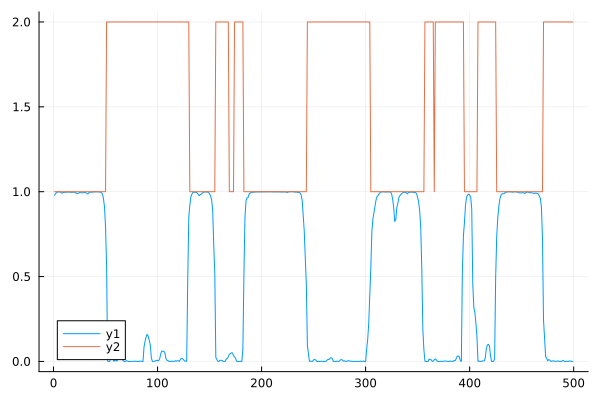

In [135]:
plot(r1)
plot!(test_regimes[2:end])

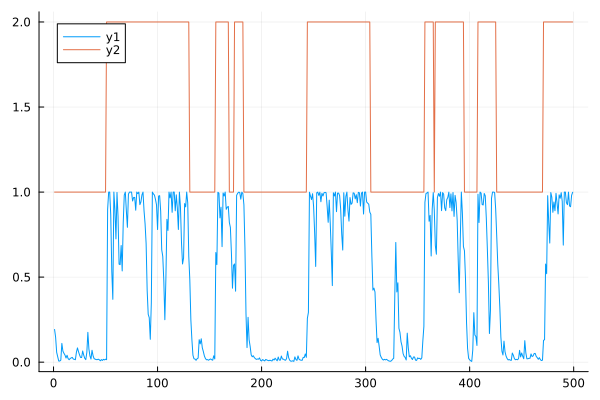

In [136]:
states_zero = [.6, .4]
regimes_probs = hamilton_filter(Y,X, Β, Σ, transition_matrix, states_zero)

plot(regimes_probs[:,2])
plot!(test_regimes[2:end])

In [137]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)


states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
cov_sample = [sample_covariance(Y, X, Β, states[1,:], k)] 

for s in 2:n
    states_zero = unconditional_regimes(transition_matrix)
    states[s, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
    push!(cov_sample, sample_covariance(Y, X, Β, states[s,:], k))    
end 

cov1_mean = mean(map(x -> x[1], cov_sample))
cov2_mean = mean(map(x -> x[2], cov_sample))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.005203670801917226
 0.0020401406281330974

"regime two"

2-element Vector{Float64}:
 0.011490857289025424
 0.0019862348193978754

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.353607
 0.353607  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.417647
 0.417647  1.0

In [129]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0'], [Σ0, Σ0], n_burn, n_sample)

([2 2 … 1 1; 2 1 … 2 2; … ; 1 1 … 1 1; 1 2 … 2 1], [0.49384808201398467 0.4739850819091847; 0.48437722107781617 0.469997344774892; … ; 0.4392824806296669 0.6779077391825645; 0.4321748555183656 0.6611083419719297;;; 0.5061519179860153 0.5260149180908154; 0.5156227789221838 0.5300026552251079; … ; 0.5607175193703331 0.32209226081743536; 0.5678251444816343 0.3388916580280704], Vector{Any}[[[0.026374906489436686 0.49679228142051757 0.09121252999451523; 0.04000190780258468 0.09705122887232624 0.47991221243940324], [0.06662185063193238 0.4170332927280742 -0.040163102270429116; 0.04059892210337524 0.1368233571495139 0.44510205204452186]], [[0.007245630293288185 0.5358367870065096 0.253782229617969; 0.0331311454611257 0.10995697263646358 0.4954286456163603], [0.07409532943846894 0.38438639889886955 -0.10411718548981952; 0.046246287694200604 0.13986761162769318 0.4369677818402674]], [[0.018094682934468323 0.5573457576282195 0.0165137258046328; 0.038350969769106645 0.13164986079768562 0.45756831

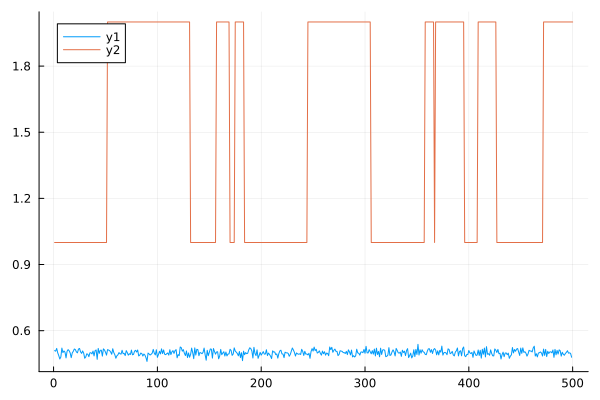

In [119]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:n_steps-1] / n_sample

plot(r1)
plot!(test_regimes)

In [120]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"transition matrix"

2×2 Matrix{Float64}:
 0.498996  0.501004
 0.499986  0.500014

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 0.0468663  0.454327  0.0199544
 0.0411288  0.125792  0.46195

"regime two"

2×3 Matrix{Float64}:
 0.0460114  0.455997  0.0269528
 0.0409176  0.125447  0.4615

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.009467701580444658
 0.002056262294905325

"regime two"

2-element Vector{Float64}:
 0.009466472251759481
 0.0020525466043390147

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.312751
 0.312751  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.311322
 0.311322  1.0